### Introduction: In this notebook we will be creating a timeseries model using lag function. We will be testing 2 models Random Forest and XGBoost and compare the performance for both of them.

In [ ]:
#Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
'''%pip install --upgrade pip
%pip uninstall pyodbc -y
%pip install -U pyodbc
%pip install xgboost
%pip install pandas==2.0.3
%pip install scikit-learn
%pip install "numpy<1.24"
%pip install==3.10.0'''
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.compat.pandas import PD_LT_2
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

#### Below is the dataframe created from the EDA notebook

In [68]:
# Load the DataFrame from the pickle file
with open('dataframe.pkl', 'rb') as file:
    df = pickle.load(file)

print("DataFrame loaded from 'dataframe.pkl':")
print(df.head(5))

DataFrame loaded from 'dataframe.pkl':
            bookings
date                
2023-07-07         3
2023-07-07         3
2023-07-07         3
2023-07-08         4
2023-07-08         4


In [69]:
# Check the column names
print("Column Names:", df.columns)

Column Names: Index(['bookings'], dtype='object')


#### Plot a time series for a single facility ID 

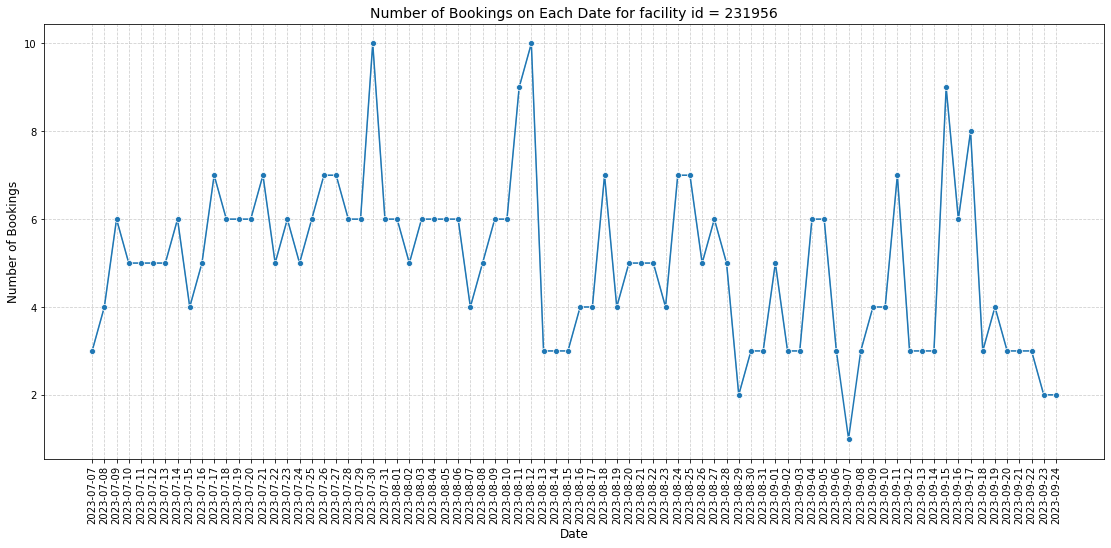

In [70]:
# Plotting
plt.figure(figsize=(19, 8))
sns.lineplot(data=df, x='date', y='bookings', marker="o")

plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Bookings', fontsize=12)
plt.title('Number of Bookings on Each Date for facility id = 231956', fontsize=14)
plt.xticks(rotation=90)
plt.grid(True, linestyle='--', alpha=0.6)

#### Find the time resolution for our dataframe

In [71]:
# Ensure the index is in datetime format
df.index = pd.to_datetime(df.index)
df = df.sort_values('date')  # Sort by time

# Compute differences between consecutive timestamps
time_diffs = df.index.to_series().diff().dropna()

# Find the most common time difference
resolution = time_diffs.mode()
print(f"Time Series Resolution: {resolution}")

Time Series Resolution: 0   0 days
Name: date, dtype: timedelta64[ns]


##### In the next part of the notebook we will be working on creating lag features which we will be using as input to our model and then further train-test splitting the dataframe. After training 2 different models we will compare the performance and decide the next steps of adjusting the paramenters for improving the performance.


In [72]:
#Create label and feature columns.
label_column = 'bookings'
feature_columns = ['bookings_min_lag', 'bookings_max_lag', 'bookings_mean_lag', 'bookings_std_lag']

#### Below are some functions to calculate lagged features. 

In [73]:
# Function to create Lagged features 
def create_lagged_stats(df, target_col, window_size=3):
    """
    Create lagged features for min, max, mean, and std dev using a rolling window.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing the target column.
    - target_col (str): Column name for which to create lagged features.
    - window_size (int): Size of the rolling window for calculating statistics.

    Returns:
    - pd.DataFrame: DataFrame with lagged statistical features.
    """
    df_lagged = df.copy() # This will create a copy of existing dataframe and assign it to new df_lagged. Next we will add the lagged columns as features to the df_lagged.
    
    # Create lagged statistical features
    df_lagged[f'{target_col}_min_lag'] = df[target_col].shift(1).rolling(window=window_size).min()
    df_lagged[f'{target_col}_max_lag'] = df[target_col].shift(1).rolling(window=window_size).max()
    df_lagged[f'{target_col}_mean_lag'] = df[target_col].shift(1).rolling(window=window_size).mean()
    df_lagged[f'{target_col}_std_lag'] = df[target_col].shift(1).rolling(window=window_size).std()

    # Drop rows with NaN values caused by rolling window
    df_lagged.dropna(inplace=True)

    return df_lagged

#### Below we are creating a function to perform sequential splitting of the data 

In [74]:
# Function to create Sequential split for training and testing of the time series df
def sequential_train_test_split(df, train_ratio):
        train_size = int(len(df) * train_ratio)

        # Sequential split
        train_df = df.iloc[:train_size]
        test_df = df.iloc[train_size:]

        print(f"Train size: {train_df.shape}, Test size: {test_df.shape}")
        print("Train Data Sample:\n", train_df.head(2))
        print("Train Data Sample:\n", test_df.head(2))
        
        # Separate Features and Label 
        X_train, y_train = train_df[feature_columns], train_df[label_column]
        X_test, y_test = test_df[feature_columns], test_df[label_column]

        # Display the shapes for verification
        print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
        print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
        return X_train, y_train, X_test, y_test

#### Below we will define 3 model training functions: Linear Regression, Random Forest and XGBoost.

In [75]:
def train_linear_regression(X_train, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

def train_random_forrest(X_train, y_train):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

def train_xgboost(X_train, y_train):
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    model.fit(X_train, y_train)
    return model


#### Below we will define function for Model Evaluation

In [77]:
def evalute_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # Evaluate Model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mape_percent = str(round(mape * 100, 2)) + "%"
    r2 = r2_score(y_test, y_pred)

    print("\n--- Error Metrics ---")
    print(f"MAE: {mae:.3f}")
    print(f"MSE: {mse:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print("MAPE:", mape_percent)

    # Plot Actual vs Predictions
    df_plot = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})

    # Plot using Seaborn
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_test, y=y_pred, color='blue', s=50)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)  # Perfect Prediction Line

    plt.xlabel('No. of True Bookings')
    plt.ylabel('No. of Predicted Bookings')
    plt.title('No. of True Bookings vs No. of Predicted Bookings')
    #plt.legend()
    plt.legend(['Perfect Prediction Line', 'Predicted Values'], loc='lower right')
    plt.grid(True)
    plt.show()
    return y_test, y_pred


In [78]:
# Define train-test split ratio
train_ratio = 0.70
df_lagged = create_lagged_stats(df, target_col='bookings', window_size=2)
X_train, y_train, X_test, y_test = sequential_train_test_split(df_lagged, train_ratio)
df_lagged.shape

Train size: (279, 5), Test size: (120, 5)
Train Data Sample:
             bookings  bookings_min_lag  bookings_max_lag  bookings_mean_lag  \
date                                                                          
2023-07-07         3               3.0               3.0                3.0   
2023-07-08         4               3.0               3.0                3.0   

            bookings_std_lag  
date                          
2023-07-07               0.0  
2023-07-08               0.0  
Train Data Sample:
             bookings  bookings_min_lag  bookings_max_lag  bookings_mean_lag  \
date                                                                          
2023-08-26         5               5.0               7.0                6.0   
2023-08-26         5               5.0               5.0                5.0   

            bookings_std_lag  
date                          
2023-08-26          1.414214  
2023-08-26          0.000000  
X_train shape: (279, 4), y_train sha

(399, 5)

Linear Regression Model

--- Error Metrics ---
MAE: 0.717
MSE: 1.485
RMSE: 1.219
MAPE: 20.33%


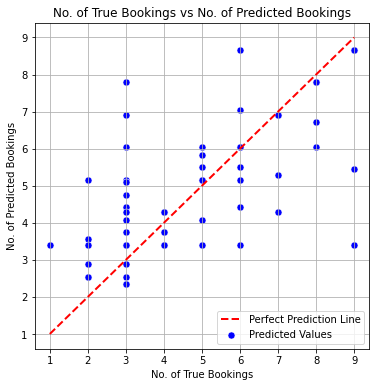

In [79]:
print('Linear Regression Model')
model = train_linear_regression(X_train, y_train)
lr_y_test, lr_y_pred = evalute_model(model, X_test, y_test)


Random Forest Model

--- Error Metrics ---
MAE: 0.695
MSE: 1.612
RMSE: 1.269
MAPE: 19.75%


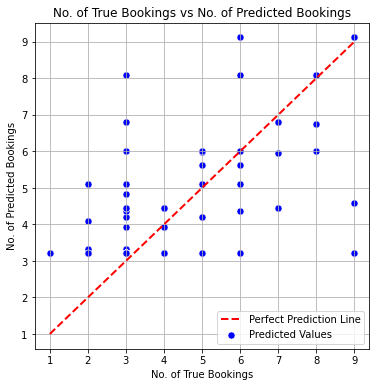

In [80]:
print('Random Forest Model')
model = train_random_forrest(X_train, y_train)
rf_y_test, rf_y_pred = evalute_model(model, X_test, y_test)

XGBoost Model

--- Error Metrics ---
MAE: 0.746
MSE: 1.829
RMSE: 1.352
MAPE: 20.11%


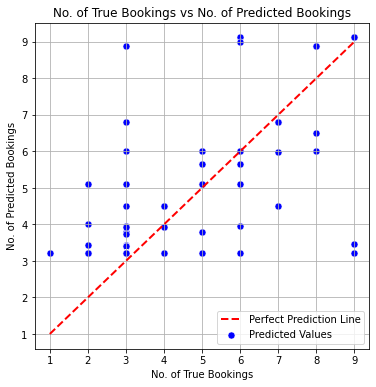

In [81]:
print('XGBoost Model')
model = train_xgboost(X_train, y_train)
xg_y_test, xg_y_pred = evalute_model(model, X_test, y_test)

### In the above graphs
1. The area above the predicted line suggests that the predicted values are higher than the true values. Specially it is higher for true value  of number of  bookings = 3. It means that the model is overestimating the true values of these data points.
2. The area below the predicted line suggests the predicted values are lower than the true values. The model is underestimating the actual data points. 

#### Graph to compare model performances 

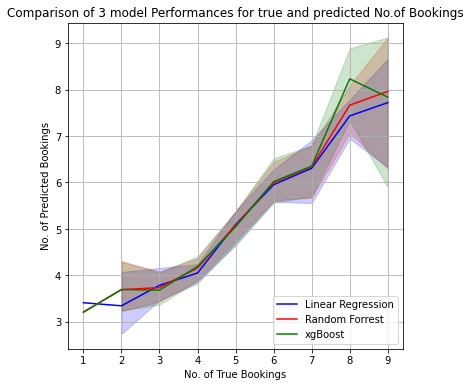

In [85]:
# Plot True vs Prediction Values for Linear Regression, Random Forest and xgBoost Models.

# Plot using Seaborn
plt.figure(figsize=(6, 6))
sns.lineplot(x=lr_y_test, y=lr_y_pred, color='blue')
sns.lineplot(x=rf_y_test, y=rf_y_pred, color='red')
sns.lineplot(x=xg_y_test, y=xg_y_pred, color='green')

plt.xlabel('No. of True Bookings')
plt.ylabel('No. of Predicted Bookings')
plt.title('Comparison of 3 model Performances for true and predicted No.of Bookings')

#plt.legend()
plt.legend(['Linear Regression', 'Random Forrest', 'xgBoost'], loc='lower right')
plt.grid(True)
plt.show()

For the above graph it suggests that almost all 3 models give a better performance for number of bookings from 4 to 6. The performance is not that great for lower and higher number of bookings for a given date.

### Summary
#### According to the performance metrics-The MAPE score for Random Forest is lowest with 19.75% with window size=2 and train ratio 0.70
#### MAE, MSE, and RMSE: Lower values are better.



### Next Steps
#### Plot the ACF and PACF plots for the dataset to find the best lag.